In [1]:
# !apt-get install -y \
#     libgl1-mesa-dev \
#     libgl1-mesa-glx \
#     libglew-dev \
#     libosmesa6-dev \
#     software-properties-common \
#     patchelf \
#     xvfb

In [2]:
# !pip install gym==0.21.0
# !pip install transformers
# !pip install datasets
# !pip install xvfbwrapper
# !pip install huggingface_hub
# pip install gym==0.21.0

In [3]:
import os
import random
from dataclasses import dataclass
import pickle

import numpy as np
import torch
import torch.nn as nn
from datasets import Dataset, load_dataset
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

os.environ["WANDB_DISABLED"] = "true"

/home/jupyter-msiper/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
@dataclass
class DecisionTransformerGymDataCollator:
    return_tensors: str = "pt"
    max_len: int = 125 #subsets of the episode we use for training
    state_dim: int = 484  # size of state space
    act_dim: int = 8  # size of action space
    max_ep_len: int = 1000 # max episode length in the dataset
    scale: float = 1000.0  # normalization of rewards/returns
    state_mean: np.array = None  # to store state means
    state_std: np.array = None  # to store state stds
    p_sample: np.array = None  # a distribution to take account trajectory lengths
    n_traj: int = 0 # to store the number of trajectories in the dataset

    def __init__(self, dataset) -> None:
        self.act_dim = len(dataset[0]["actions"][0])
        self.state_dim = len(dataset[0]["observations"][0])
        self.dataset = dataset
        # calculate dataset stats for normalization of states
        states = []
        traj_lens = []
        for i, d in enumerate(dataset):
            obs = d["observations"]
            states.extend(obs)
            traj_lens.append(len(obs))
        self.n_traj = len(traj_lens)
        print(f"self.n_traj: {self.n_traj}")
        states = np.vstack(states)
        self.state_mean, self.state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6
        
        traj_lens = np.array(traj_lens)
        self.p_sample = traj_lens / sum(traj_lens)
        self._inds_used_in_training = []

    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum

    def __call__(self, features):
        batch_size = len(features)
        # this is a bit of a hack to be able to sample of a non-uniform distribution
        batch_inds = np.random.choice(
            np.arange(self.n_traj),
            size=batch_size,
            replace=True,
            p=self.p_sample,  # reweights so we sample according to timesteps
        )
        open("/home/jupyter-msiper/bootstrapping-pcgrl/inds_used.txt", "w").write('\n'.join([str(i) for i in batch_inds]))
        # a batch of dataset features
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            # for feature in features:
            self._inds_used_in_training.append(int(ind))
            feature = self.dataset[int(ind)]
            si = random.randint(0, len(feature["rewards"]) - 1)
            # si = 0

            # get sequences from dataset
            s.append(np.array(feature["observations"][si : si + self.max_len]).reshape(1, -1, self.state_dim))
            a.append(np.array(feature["actions"][si : si + self.max_len]).reshape(1, -1, self.act_dim))
            r.append(np.array(feature["rewards"][si : si + self.max_len]).reshape(1, -1, 1))

            d.append(np.array(feature["dones"][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            rtg.append(
                self._discount_cumsum(np.array(feature["rewards"][si:]), gamma=1.0)[
                    : s[-1].shape[1]   # TODO check the +1 removed here
                ].reshape(1, -1, 1)
            )
            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state + reward normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - self.state_mean) / self.state_std
            # a[-1] = np.concatenate(
            #     [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
            #     axis=1,
            # )
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)), a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1) / self.scale
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))

        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        }
    
    
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output[1]
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        
        # pred_indices = action_preds.argmax(dim=-1)
        # target_indices = action_targets.argmax(dim=-1)

        # loss = torch.mean((action_preds - action_targets) ** 2)
        loss = nn.CrossEntropyLoss()(action_preds, action_targets)

        return {"loss": loss}

    def original_forward(self, **kwargs):
        return super().forward(**kwargs)
    

# data = np.load("/home/jupyter-msiper/bootstrapping-pcgrl/raw_dataset_data_lg.npz")
# dataset = Dataset.from_dict({item: data[item] for item in data.files})

# Check here you can load the pkl dataset bootstrapping-pcgrl/raw_dataset_data_lg_temp.pkl and train
dataset = None
with open('/home/jupyter-msiper/bootstrapping-pcgrl/raw_dataset_dt_lg_10K_episodes.pkl', 'rb') as f:
    dataset = pickle.load(f)

collator = DecisionTransformerGymDataCollator(dataset)

config = DecisionTransformerConfig(state_dim=collator.state_dim, act_dim=collator.act_dim)

config.hidden_size = 512
config.n_head = 1
config.scale_attn_by_inverse_layer_idx = True
model = TrainableDT(config)
print(config)
collator._inds_used_in_training

self.n_traj: 1000
DecisionTransformerConfig {
  "_attn_implementation_autoset": true,
  "act_dim": 8,
  "action_tanh": true,
  "activation_function": "relu",
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "max_ep_len": 4096,
  "model_type": "decision_transformer",
  "n_head": 1,
  "n_inner": null,
  "n_layer": 3,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": true,
  "scale_attn_weights": true,
  "state_dim": 484,
  "transformers_version": "4.47.1",
  "use_cache": true,
  "vocab_size": 1
}



[]

In [5]:
!export CUDA_VISIBLE_DEVICES=0
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [5]:
training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=1000,
    per_device_train_batch_size=256,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collator,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/home/jupyter-msiper/.conda/envs/bs_pcgrl_py_310/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:37: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(
/home/jupyter-msiper/.conda/envs/bs_pcgrl_py_310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.098300
1000,0.083400
1500,0.083300
2000,0.083300


/home/jupyter-msiper/.conda/envs/bs_pcgrl_py_310/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)
/home/jupyter-msiper/.conda/envs/bs_pcgrl_py_310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jupyter-msiper/.conda/envs/bs_pcgrl_py_310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jupyter-msiper/.conda/envs/bs_pcgrl_py_310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarn

TrainOutput(global_step=2000, training_loss=0.08708366394042968, metrics={'train_runtime': 1310.7979, 'train_samples_per_second': 762.894, 'train_steps_per_second': 1.526, 'total_flos': 1.4470720572e+18, 'train_loss': 0.08708366394042968, 'epoch': 1000.0})

In [6]:
# NEXT STEPS:
# 1) Implement inference for zelda narrow using the 'get_action' method and the '# Interact with the environment and create a video'
# section in the 101_train-decision-transformers.ipynb notebook to the right.

# 2) build the proper methods in inference to convert to and from states/actions
# so the interaction between pcgrl_env and dt_model (i.e. floats for states vs. ohs for pcgrl_env)
# is seamless

# 3) Run inference via feeding the model the first state from  observation from raw_dataset_data.npz 
# and confirm that it can build a solveable level!

# Function that gets an action from the model using autoregressive prediction with a window of the previous 20 timesteps.
def get_action(model, states, actions, rewards, returns_to_go, timesteps):
    # This implementation does not condition on past rewards
    # model.config.max_length = 100

    states = states.reshape(1, -1, model.config.state_dim)
    actions = actions.reshape(1, -1, model.config.act_dim)
    returns_to_go = returns_to_go.reshape(1, -1, 1)
    timesteps = timesteps.reshape(1, -1)

    states = states[:, -model.config.max_length :]
    actions = actions[:, -model.config.max_length :]
    returns_to_go = returns_to_go[:, -model.config.max_length :]
    timesteps = timesteps[:, -model.config.max_length :]
    padding = model.config.max_length - states.shape[1]
    # pad all tokens to sequence length
    attention_mask = torch.cat([torch.zeros(padding), torch.ones(states.shape[1])])
    attention_mask = attention_mask.to(dtype=torch.long).reshape(1, -1)
    states = torch.cat([torch.zeros((1, padding, model.config.state_dim)), states], dim=1).float()
    actions = torch.cat([torch.zeros((1, padding, model.config.act_dim)), actions], dim=1).float()
    returns_to_go = torch.cat([torch.zeros((1, padding, 1)), returns_to_go], dim=1).float()
    timesteps = torch.cat([torch.zeros((1, padding), dtype=torch.long), timesteps], dim=1)

    state_preds, action_preds, return_preds = model.original_forward(
        states=states,
        actions=actions,
        rewards=rewards,
        returns_to_go=returns_to_go,
        timesteps=timesteps,
        attention_mask=attention_mask,
        return_dict=False,
    )

    return action_preds[0, -1]




In [7]:
def transform_state(obs, x, y, obs_size):
    map = obs
    size = obs_size
    pad = obs_size // 2
    padded = np.pad(map, pad, constant_values=1)
    cropped = padded[y: y + size, x: x + size]
    
    return cropped


def show_state(env, step=0, changes=0, total_reward=0, name=""):
    fig = plt.figure(10)
    plt.clf()
    plt.title("{} | Step: {} Changes: {} Total Reward: {}".format(name, step, changes, total_reward))
    plt.axis('off')
    plt.imshow(env.render(mode='rgb_array'))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    
    
model = TrainableDT.from_pretrained("/home/jupyter-msiper/bootstrapping-pcgrl/output/checkpoint-2000")
model.eval()
model = model.to("cpu")

from gym_pcgrl.envs.pcgrl_env import PcgrlEnv
from utils import make_vec_envs as mkvenv


max_ep_len = 1000
device = "cpu"
scale = 1.0 #1000.0  # normalization for rewards/returns
TARGET_RETURN = 87 / scale  # evaluation is conditioned on a return of 12000, scaled accordingly

state_mean = collator.state_mean.astype(np.float32)
state_std = collator.state_std.astype(np.float32)
# print(state_mean)

state_dim = 484#env.observation_space.shape[0]
act_dim = 8#env.action_space.shape[0]


state_mean = torch.from_numpy(state_mean).to(device=device)
state_std = torch.from_numpy(state_std).to(device=device)


def infer(model, trial_num, total_solved):
    # Interact with 2085 environment and create a video
    seen_levels = [int(ind) for ind in open("/home/jupyter-msiper/bootstrapping-pcgrl/inds_used.txt", "r").readlines()]
    EPISODE_INDEX = random.choice(seen_levels)
    print(f"Epsiode start: {EPISODE_INDEX}")
    episode_return, episode_length = 0, 0
    env = PcgrlEnv(prob="zelda", rep="narrow")
    state = env.reset()
    # env._rep._map = (dataset[EPISODE_INDEX]['observations'][0]*8.0).astype(int).reshape(22,22)[10:10+7, 10:10+11]
    
    start_state = env.reset()
    # data['obs']
    # print(state)
    target_return = torch.tensor(TARGET_RETURN, device=device, dtype=torch.float32).reshape(1, 1)
    states = torch.from_numpy(transform_state(start_state['map'], env._rep._x, env._rep._y, 22)/8.0).reshape(1, state_dim).to(device=device, dtype=torch.float32)
    # states = torch.from_numpy(start_state['map']).to(device=device, dtype=torch.float32)
    actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
    rewards = torch.zeros(0, device=device, dtype=torch.float32)
    print(f"max_ep_len: {max_ep_len}")
    done = solved = False
    t = 0
    timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
    while not done or not solved:
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
        rewards = torch.cat([rewards, torch.zeros(1, device=device)])

        action = get_action(
            model,
            (states - state_mean) / state_std,
            actions,
            rewards,
            target_return,
            timesteps,
        )
        actions[-1] = action
        action = action.detach().cpu().numpy()
        action = np.argmax(action) + 1
        # print(f"action: {action}")

        state, reward, done, info = env.step(action)
        show_state(env, step=0, changes=0, total_reward=0, name=f"Trial: {trial_num}, num_solved: {total_solved}")
        actions[-1] = action / 8.0
        solved = info['solved']


        cur_state = torch.from_numpy(transform_state(state['map'], env._rep._x, env._rep._y, 22)/8.0).to(device=device).reshape(1, state_dim)
        states = torch.cat([states, cur_state], dim=0)
        rewards[-1] = reward

        pred_return = target_return[0, -1] - (reward / scale)
        target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
        timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t + 1)], dim=1)

        episode_return += reward
        episode_length += 1
        print(f"episode_return: {episode_return}, solved: {solved}, done: {done}")
        t += 1

        if done or solved or t >= 350:
            # input('')
            # env.reset()
            # env._rep._map = (dataset[EPISODE_INDEX]['observations'][0]*8.0).astype(int).reshape(22,22)[10:10+7, 10:10+11]
            if solved:
                # input('')
                return True
                
            else:
                return False

/home/jupyter-msiper/.conda/envs/bs_pcgrl_py_310/lib/python3.10/site-packages/np_utils/np_utils.py:88: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if StrictVersion(np.__version__) < StrictVersion("1.11.0"):


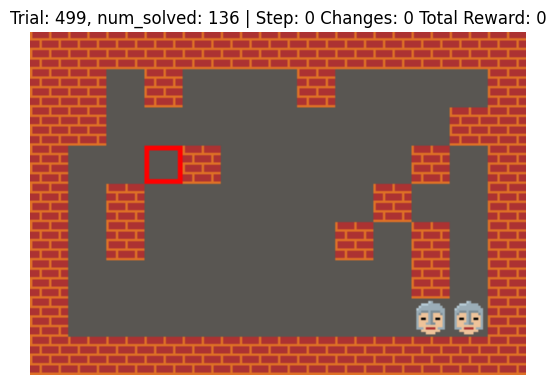

episode_return: 34, solved: False, done: False
Pct solved: 0.272


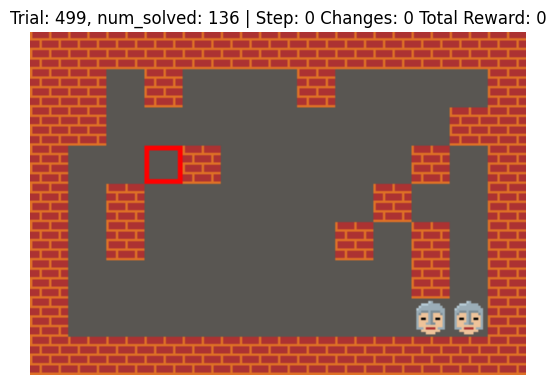

In [8]:
# Next steps:
# I want to append multiple episodes to the same trajectory to confirm I can train large dataset with the DataCollator object
# Test with using the cumulative reward from the PoD trajectory
# env = PcgrlEnv(prob="zelda", rep="narrow")
NUM_TRIALS = 500
num_solved = 0
for t_i in range(NUM_TRIALS):
    level_solved = infer(model, t_i, num_solved)
    num_solved += int(level_solved)
    
print(f"Pct solved: {num_solved/float(NUM_TRIALS)}")